In [365]:
import csv
import os
from pathlib import Path


import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from typing import Dict, List, Tuple, Union


from torch.utils.data import Dataset,DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchaudio.transforms import MelSpectrogram
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_commonvoice_item(
    line: List[str], header: List[str], path: str, folder_audio: str, ext_audio: str
) -> Tuple[Tensor, int, Dict[str, str]]:
    # Each line as the following data:
    # client_id, path, sentence, up_votes, down_votes, age, gender, accent

    if header[1] != "path":
        raise ValueError(f"expect `header[1]` to be 'path', but got {header[1]}")
    fileid = line[1]
    filename = os.path.join(path, folder_audio, fileid)
    if not filename.endswith(ext_audio):
        filename += ext_audio
    waveform, sample_rate = torchaudio.load(filename)

    dic = dict(zip(header, line))
    return waveform, sample_rate, dic

class COMMONVOICE(Dataset):
    _ext_audio = ".mp3"
    _folder_audio = "clips"

    def __init__(self, root: Union[str, Path], tsv: str = "train.tsv", transform=None):
        self._path = os.fspath(root)
        self._tsv = os.path.join(self._path, tsv)
        with open(self._tsv, "r") as tsv_:
            walker = csv.reader(tsv_, delimiter="\t")
            self._header = next(walker)
            self._walker = [row for row in walker if row[self._header.index('sentence')] not in  ['Hey','Firefox','zéro','cinq','six','sept','huit','neuf']]
        self.transform = transform or MelSpectrogram()

    def __getitem__(self, n: int) -> Tuple[torch.Tensor, str]:
        line = self._walker[n]
        waveform, _, dic = load_commonvoice_item(line, self._header, self._path, self._folder_audio, self._ext_audio)
        spectrogram = self.transform(waveform).squeeze(0)  # Apply transformation and remove channel dim
        label = dic["sentence"]
        return spectrogram, label

    def __len__(self) -> int:
        return len(self._walker)


In [366]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)  # Assuming spectrogram is [1, Freq, Time]
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(3520, 512)  # Adjust the size based on your spectrogram's size after pooling
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [367]:
import torch

map_test = {
    'un': 0,
    'deux': 1,
    'trois': 2,
    'quatre': 3,
    'oui': 4,
    'non': 5,
}

def collate_fn(batch):
    # Unpack the batch items (spectrograms and labels)
    spectrograms, labels = zip(*batch)
    
    # Find the maximum length of the time frames in the batch
    max_length = 880
    
    # Pad the spectrograms to have the same time frame length
    padded_specs = [F.pad(spec, (0, max_length - spec.shape[-1])) for spec in spectrograms]
    
    # Stack the padded spectrograms into a single tensor
    spectrograms_padded = torch.stack(padded_specs)
    
    # Convert labels to a tensor (assuming labels are already numerical or have been processed)
    labels = torch.tensor([map_test[label] for label in labels], dtype=torch.long)
    
    return spectrograms_padded, labels



In [368]:
transform = MelSpectrogram(sample_rate=48000, n_mels=64, n_fft=1024, hop_length=512)
dataset = COMMONVOICE(root="./data/cv-corpus-7.0-singleword/fr", tsv="train.tsv", transform=transform)

max_length = 0
transform = MelSpectrogram(sample_rate=48000, n_mels=128)  # Example transform

for index in range(len(dataset)):
    spectrogram, label = dataset[index]  # Assuming this returns the waveform and label
    if spectrogram.shape[-1] > max_length:
        max_length = spectrogram.shape[-1]

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn,drop_last=True)

model = SimpleCNN(num_classes=6)  # Adjust num_classes as per your task


max_length

/Users/robinbochu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


880

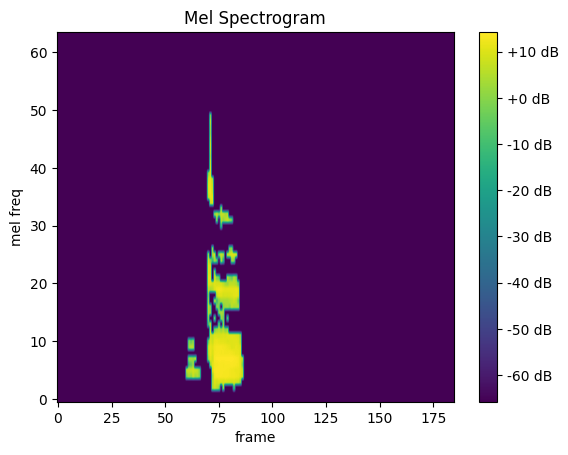

In [369]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
def plot_spectrogram(spectrogram, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    """
    Plots a spectrogram.
    
    Parameters:
        spectrogram (Tensor): A spectrogram with shape [Frequency, Time].
        title (str, optional): Title of the plot.
        ylabel (str, optional): Label of the y-axis.
        aspect (str, optional): Aspect ratio of the plot.
        xmax (int, optional): Maximum value of the x-axis.
    """
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (dB)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spectrogram), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs, format="%+2.0f dB")
    plt.show(block=False)



# Assuming 'waveform' is your audio tensor with shape [Channels, Time]
# and 'sample_rate' is the sample rate of your audio

# Create a MelSpectrogram transformation object (if not already defined)
transform = torchaudio.transforms.MelSpectrogram(sample_rate=48000, n_mels=128)


# Convert to dB scale for visualization
spectrogram_db = torchaudio.transforms.AmplitudeToDB()(dataset[1][0])
# Plot the spectrogram
plot_spectrogram(spectrogram_db.numpy(), title='Mel Spectrogram', ylabel='mel freq')


In [370]:
# This is a very basic loop; real training code will need optimization, logging, validation, etc.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Assuming a classification task
model.train()
for epoch in range(5):
    for batch_idx, (spectrograms, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        outputs = model(spectrograms)
        # Assuming labels are processed into a suitable format for CrossEntropyLoss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")
        


torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size([32, 3520])
torch.Size(

In [ ]:
train_dataset = COMMONVOICE(root="./data/cv-corpus-7.0-singleword/fr", tsv="train.tsv", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn,drop_last=True)

model.eval()
for spectrograms, labels in train_loader:
    outputs = model(spectrograms)
    _, predicted = torch.max(outputs, 1)
    print(f"Predicted: {predicted}")
    print(f"True: {labels}")
    